## Imports

In [1]:
pip install -r requirements.txt

  Using cached scikit_learn-1.3.2-cp39-cp39-win_amd64.whl (9.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.47.2 requires slicer==0.0.8, but you have slicer 0.0.7 which is incompatible.
eli5 0.16.0 requires scikit-learn>=1.6.0, but you have scikit-learn 1.3.2 which is incompatible.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    RocCurveDisplay,
    PrecisionRecallDisplay,
    confusion_matrix,
    accuracy_score,
    f1_score
)




c:\Users\tomba\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\tomba\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


**Dataset Loading**

In [3]:
file_path = 'Student Depression Dataset.csv'
df = pd.read_csv(file_path)

## Pre Proccessing

In [4]:
# Feature selection - Removing the 'id' column
df = df.drop(columns=['id'])

#Removing the non students 
df = df[df['Profession'] == 'Student'].drop(columns=['Profession'])
df = df[df['Degree'] != 'Others']

**NaN values handeling**

In [5]:
# Locate cols with missing values
missing_cols = list(df.columns[df.isna().any()])
print(missing_cols)

['Financial Stress']


In [6]:
# NA filling
mean_value = df['Financial Stress'].mean()
df['Financial Stress'] = df['Financial Stress'].fillna(mean_value)

**Sleep duration**

In [7]:
# Mapping sleep duration column to numeric values
mapping = {
    'Less than 5 hours': 4.5,
    '5-6 hours': 5.5,
    '7-8 hours': 7.5,
    'More than 8 hours': 9
}
df['Sleep Duration'] = df['Sleep Duration'].map(mapping)
df = df[df['Sleep Duration'].notna()] # Remove rows with NaN 




**Diet**

In [8]:

# Mapping diet column to numeric values
mapping_diet = {
    'Healthy': 3,
    'Moderate': 2,
    'Unhealthy': 1
}
df['Dietary Habits'] = df['Dietary Habits'].map(mapping_diet)
df = df[df['Dietary Habits'].notna()] # Remove rows with NaN 


**Suicidal thoughts & Mental illness history conversion to numeric values**

In [9]:
# Mapping Yes/No values in 'Have you ever had suicidal thoughts ?' and 'Family History of Mental Illness' columns to 1 and 0
yes_no_mapping = {'Yes': 1, 'No': 0}
df['Have you ever had suicidal thoughts ?'] = df['Have you ever had suicidal thoughts ?'].map(yes_no_mapping)
df['Family History of Mental Illness'] = df['Family History of Mental Illness'].map(yes_no_mapping)

**Gender, City and Degree handeling**

In [10]:
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['City'] = df['City'].map(df['City'].value_counts())

# Classifying the 'Degree' column into three categories
df.loc[df['Degree'].str.contains(r'BSc|BCA|B.Ed|BHM|B.Pharm|B.Com|BE|BA|B.Arch|B.Tech|BBA|LLB|MBBS', regex=True, na=False), 'Degree'] = 'Graduated'
df.loc[df['Degree'].str.contains(r'MSc|MCA|M.Ed|M.Pharm|M.Com|ME|MA|M.Arch|M.Tech|MBA|LLM|MD|PhD|MHM', regex=True, na=False), 'Degree'] = 'Post Graduated'
df.loc[df['Degree'] == 'Class 12', 'Degree'] = 'Higher Secondary'


degree_mapping = {
    'Higher Secondary': 1,
    'Graduated': 2,
    'Post Graduated': 3
}

df['Degree'] = df['Degree'].map(degree_mapping)


## Feature Engineering

In [11]:
# Calculating a new feature Lifestyle Score that reflects overall health by weighting sleep and diet positively, and financial stress negatively
df['Lifestyle Score'] = (
    df['Sleep Duration'] * 0.4 + df['Dietary Habits'] * 1.5 - df['Financial Stress'] * 0.8
)

In [12]:
# No null values in the dataset validation
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Gender                                   0
Age                                      0
City                                     0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
Lifestyle Score                          0
dtype: int64


# ML Models

## Random Forest

In [13]:
df_rf = df.copy()

X = df_rf.drop(columns=['Depression'])
y = df_rf['Depression']

#  Train/test split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)

#  Define hyperparameter grid
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

#  Initialize and tune Random Forest
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(estimator=rf, param_grid=rf_params, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf_model = rf_grid.best_estimator_


#  Evaluation
print(" Best Hyperparameters:")
print(rf_grid.best_params_)

print("\n Classification Report:")
y_pred = rf_grid.predict(X_test)
print(classification_report(y_test, y_pred))

 Best Hyperparameters:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      2307
           1       0.86      0.89      0.87      3254

    accuracy                           0.85      5561
   macro avg       0.85      0.84      0.84      5561
weighted avg       0.85      0.85      0.85      5561



## Xgboost

In [14]:
xgb_df = df.copy()
X = xgb_df.drop(columns=['Depression'])
y = xgb_df['Depression']

#  Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 4. Define hyperparameter grid
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

# Initialize XGBoost model
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

#  Hyperparameter tuning 
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_params,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train, y_train)
best_xgb_model = xgb_search.best_estimator_


# 7. Evaluation
print("🔍 Best XGBoost Hyperparameters:")
print(xgb_search.best_params_)

print("\n Classification Report:")
y_pred = xgb_search.predict(X_test)
print(classification_report(y_test, y_pred))

c:\Users\tomba\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tomba\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\tomba\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


🔍 Best XGBoost Hyperparameters:
{'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 1.0}

 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2307
           1       0.87      0.89      0.88      3254

    accuracy                           0.85      5561
   macro avg       0.85      0.85      0.85      5561
weighted avg       0.85      0.85      0.85      5561



## Neural Network

In [15]:
#  Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#  Data prep
nn_df = df.copy()
X = nn_df.drop(columns=['Depression'])
y = nn_df['Depression']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

#  Feature scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and compile model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])
nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = nn_model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


#  Predict and evaluate
y_pred = (nn_model.predict(X_test_scaled) > 0.5).astype(int)

print("\n Neural Network Classification Report:")
print(classification_report(y_test, y_pred))

c:\Users\tomba\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7811 - loss: 0.4673 - val_accuracy: 0.8373 - val_loss: 0.3684
Epoch 2/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8369 - loss: 0.3714 - val_accuracy: 0.8379 - val_loss: 0.3657
Epoch 3/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8427 - loss: 0.3648 - val_accuracy: 0.8397 - val_loss: 0.3653
Epoch 4/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8433 - loss: 0.3613 - val_accuracy: 0.8386 - val_loss: 0.3659
Epoch 5/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8458 - loss: 0.3609 - val_accuracy: 0.8393 - val_loss: 0.3660
Epoch 6/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8456 - loss: 0.3567 - val_accuracy: 0.8395 - val_loss: 0.3651
Epoch 7/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8452 - loss: 0.3591 - val_accuracy: 0.8411 - val_loss: 0.3661
Epoch 8/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8481 - loss: 0.3554 - val_accuracy: 0.

## Ensamble

In [16]:
# 1. Get predicted probabilities
proba_rf = best_rf_model.predict_proba(X_test_scaled)
proba_xgb = best_xgb_model.predict_proba(X_test_scaled)
proba_nn = nn_model.predict(X_test_scaled)

# 2. Ensure correct shape
if len(proba_nn.shape) == 1:
    proba_nn = proba_nn.reshape(-1, 1)

# 3. Build [p0, p1] for NN
proba_nn_full = np.hstack([1 - proba_nn, proba_nn])

# 4. Average all 3
avg_proba = (proba_rf + proba_xgb + proba_nn_full) / 3

# 5. Predict
final_pred = (avg_proba[:, 1] > 0.5).astype(int)

# 6. Evaluate
print("\nManual Soft Voting Classification Report:")
print(classification_report(y_test, final_pred))

  1/174 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step

c:\Users\tomba\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Manual Soft Voting Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      2307
           1       0.87      0.82      0.84      3254

    accuracy                           0.82      5561
   macro avg       0.82      0.82      0.82      5561
weighted avg       0.83      0.82      0.82      5561



# Evaluation

In [17]:
model_names = [
    "Random Forest",
    "XGBoost",
    "Neural Network",
    "Ensemble (Soft Voting)"
]

# Predictions – binary
y_pred_rf = best_rf_model.predict(X_test_scaled)
y_pred_xgb = best_xgb_model.predict(X_test_scaled)
y_pred_nn = (nn_model.predict(X_test_scaled) > 0.5).astype(int)

# Lists for looped visualization
model_preds = [y_pred_rf, y_pred_xgb, y_pred_nn, final_pred]
model_probas = [proba_rf[:, 1], proba_xgb[:, 1], proba_nn.ravel(), avg_proba[:, 1]]

  1/174 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step

c:\Users\tomba\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## ROC Curve Comparison

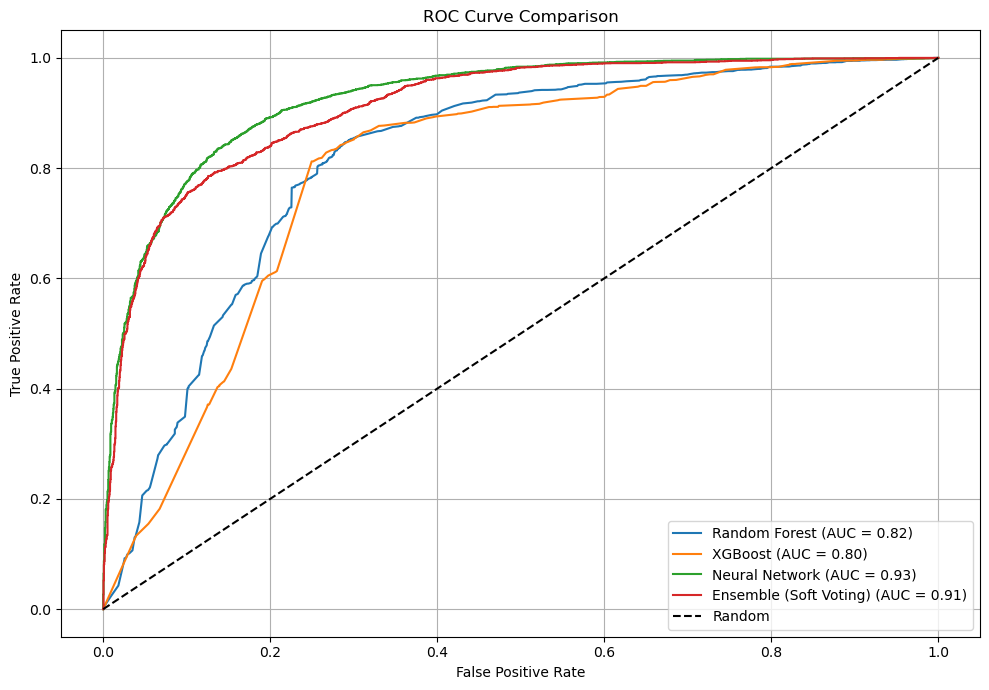

In [18]:
fig, ax = plt.subplots(figsize=(10, 7))

for name, proba in zip(model_names, model_probas):
    display = RocCurveDisplay.from_predictions(y_test, proba, name=name, ax=ax)
    # Set consistent styling for each curve
    ax.set_title("ROC Curve Comparison")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.grid(True)

# Add diagonal (random classifier)
ax.plot([0, 1], [0, 1], 'k--', label='Random')

ax.legend(loc="lower right")
plt.tight_layout()
plt.show()


## Confusion Matrix Heatmaps

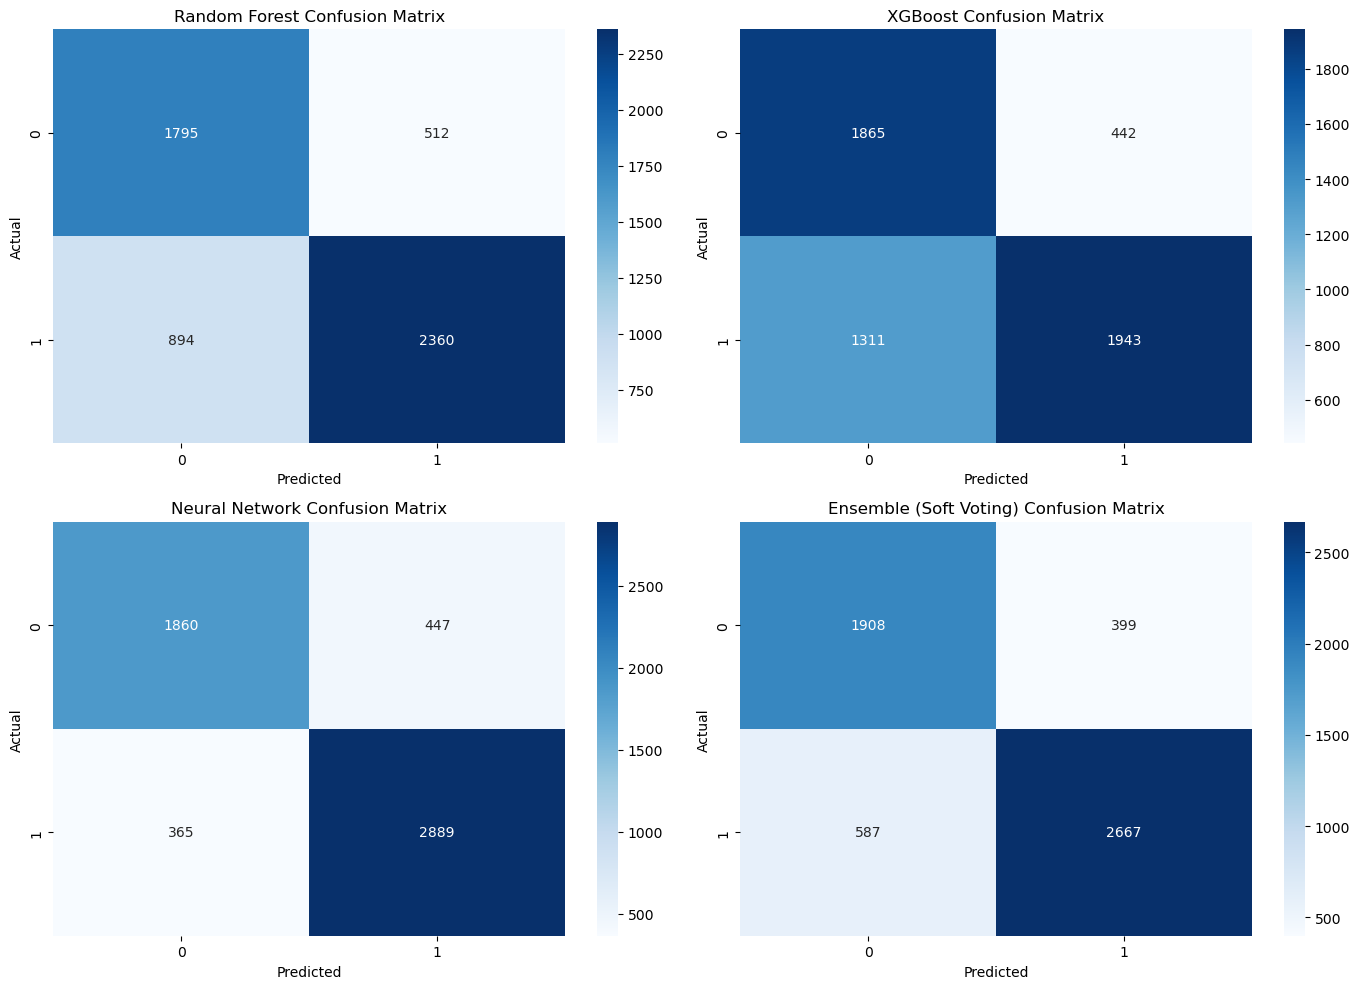

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (name, y_pred_i) in enumerate(zip(model_names, model_preds)):
    cm = confusion_matrix(y_test, y_pred_i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"{name} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

## Accuracy & F1-Score Comparison

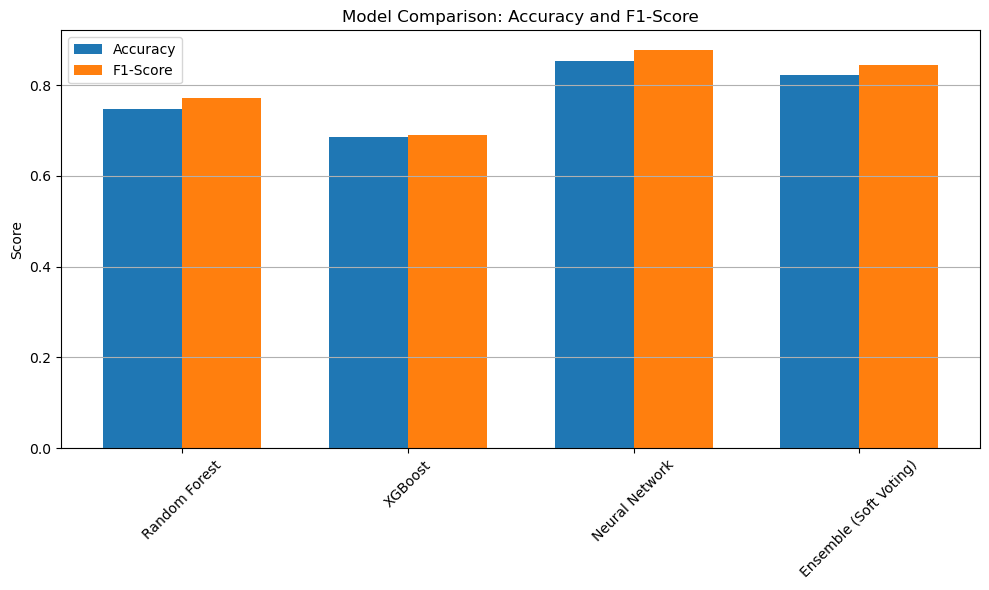

In [20]:
accs = [accuracy_score(y_test, p) for p in model_preds]
f1s = [f1_score(y_test, p) for p in model_preds]

plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(model_names))

plt.bar(x - bar_width/2, accs, bar_width, label='Accuracy')
plt.bar(x + bar_width/2, f1s, bar_width, label='F1-Score')

plt.xticks(x, model_names, rotation=45)
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy and F1-Score")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Precision-Recall Curve

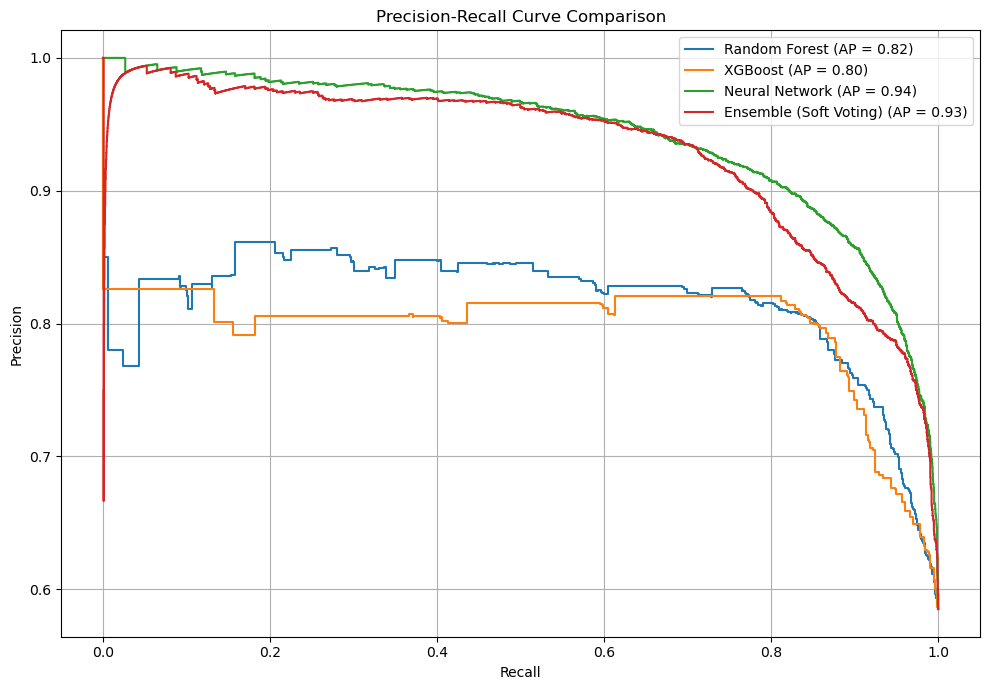

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))

for name, proba in zip(model_names, model_probas):
    PrecisionRecallDisplay.from_predictions(y_test, proba, name=name, ax=ax)

# Apply styling to the entire plot after all curves are plotted
ax.set_title("Precision-Recall Curve Comparison")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

## Permutation Importance

In [22]:
# Imports
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

def plot_permutation_importance(perm_result, model_name, feature_names):
    sorted_idx = perm_result.importances_mean.argsort()
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), perm_result.importances_mean[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel("Mean Importance")
    plt.title(f"Permutation Feature Importance – {model_name}")
    plt.tight_layout()
    plt.show()


### Random Forest 

c:\Users\tomba\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\tomba\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\tomba\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\tomba\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\tomba\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\tomba\anaconda3\lib\site-packages\sklearn\base.py:4

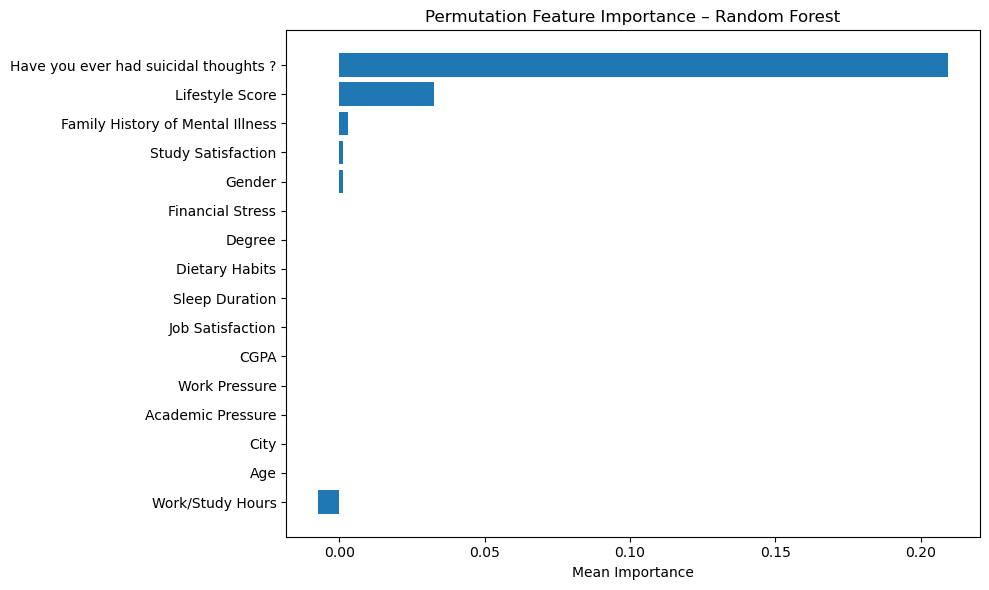

In [23]:
perm_rf = permutation_importance(best_rf_model, X_test_scaled, y_test, n_repeats=30, random_state=42)
plot_permutation_importance(perm_rf, "Random Forest", X.columns.tolist())


### XGBoost 

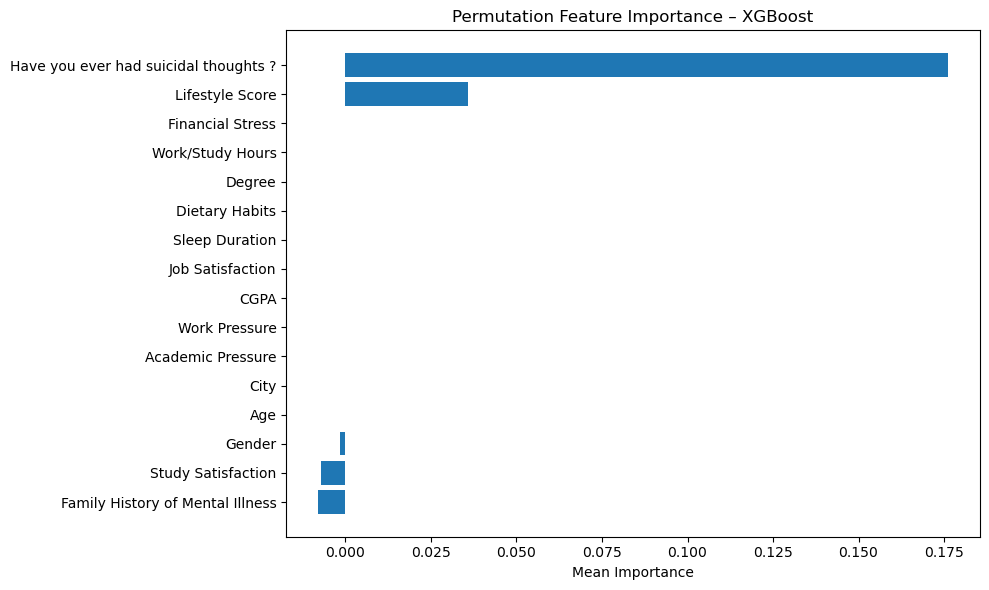

In [24]:
perm_xgb = permutation_importance(best_xgb_model, X_test_scaled, y_test, n_repeats=30, random_state=42)
plot_permutation_importance(perm_xgb, "XGBoost", X.columns.tolist())

### Neural Network

The permutation_importance function from sklearn.inspection expects an estimator that:

Implements a .predict() method that returns discrete class labels (e.g., 0 or 1).

Has a .score() method, which is used when no scoring parameter is explicitly provided.

However, a Keras Sequential model (like nn_model in our case):

Returns continuous probabilities when using .predict().

Does not implement a .score() method.

Attempting to use permutation_importance directly on such a model will result in a ValueError.

To solve this, we wrap our nn_model in a custom Python class that conforms to the sklearn estimator interface, providing compatible .predict() and .score() methods.



In [27]:
from sklearn.base import BaseEstimator, ClassifierMixin

class PredictAsBinary(BaseEstimator, ClassifierMixin):
    """
    A wrapper for Keras Sequential models that ensures compatibility
    with sklearn's permutation_importance function.
    Converts predicted probabilities to binary class labels (0 or 1).
    """
    def __init__(self, keras_model):
        self.keras_model = keras_model

    def fit(self, X, y):
        # No training required – assumes model is already trained
        return self

    def predict(self, X):
        return (self.keras_model.predict(X) > 0.5).astype(int)

    def score(self, X, y):
        return (self.predict(X).flatten() == y).mean()


174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
174/174 ━━━━━━━━

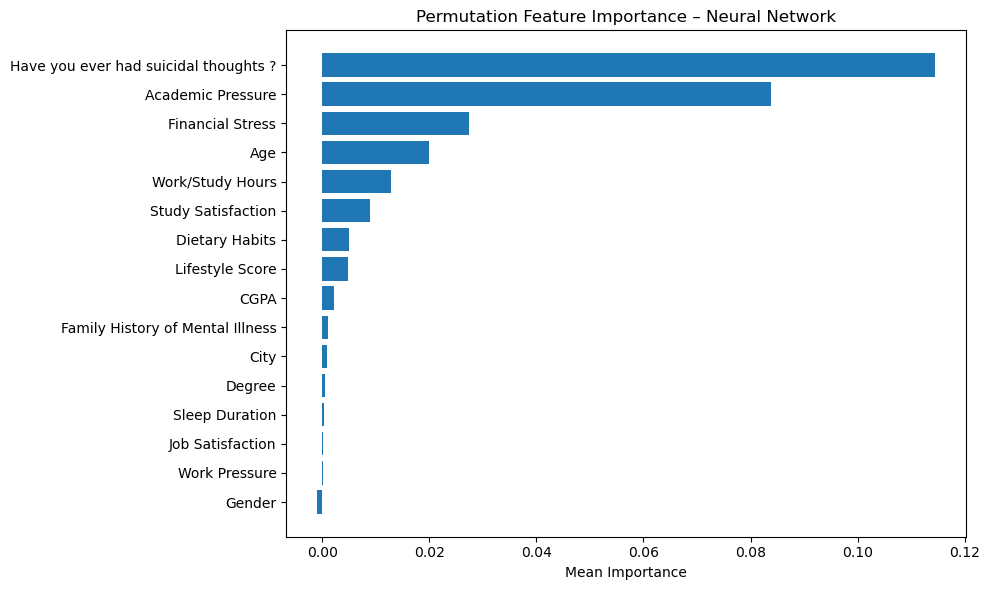

In [29]:
# Wrap the trained Keras model
wrapped_nn_model = PredictAsBinary(nn_model)

# Compute permutation importance
perm_nn = permutation_importance(
    wrapped_nn_model,
    X_test_scaled,
    y_test,
    n_repeats=5,
    random_state=42
)

# Plot results
plot_permutation_importance(perm_nn, "Neural Network", X.columns.tolist())